<a href="https://colab.research.google.com/github/vikram-available/Trading-algo/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
data = pd.read_csv('/content/drive/MyDrive/gp_forex/EURUSD1__1.0.csv', delimiter='\t')
data.head()


,2024-05-14 11:21,1.07983,1.07983.1,1.07975,1.07980,42
0,2024-05-14 11:22,1.07981,1.07981,1.07980,1.07980,6
1,2024-05-14 11:23,1.07981,1.07981,1.07969,1.07970,36
2,2024-05-14 11:24,1.07969,1.07972,1.07965,1.07972,45
3,2024-05-14 11:25,1.07973,1.07980,1.07973,1.07979,27
4,2024-05-14 11:26,1.07977,1.07980,1.07976,1.07977,40


In [32]:
df=  pd.read_csv('/content/drive/MyDrive/gp_forex/EURUSD1__1.0.csv', delimiter='\t', header=None)
df.columns= ['Datetime', 'open', 'high', 'low', 'close', 'volume']
df.set_index('Datetime', inplace=True)
#df=df.iloc[-80000:]
df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M')

df.head()



,open,high,low,close,volume
Datetime,,,,,
2024-05-14 11:21:00,1.07983,1.07983,1.07975,1.07980,42
2024-05-14 11:22:00,1.07981,1.07981,1.07980,1.07980,6
2024-05-14 11:23:00,1.07981,1.07981,1.07969,1.07970,36
2024-05-14 11:24:00,1.07969,1.07972,1.07965,1.07972,45
2024-05-14 11:25:00,1.07973,1.07980,1.07973,1.07979,27


In [33]:
df.tail()

,open,high,low,close,volume
Datetime,,,,,
2024-08-20 10:55:00,1.10808,1.10813,1.10806,1.10806,54
2024-08-20 10:56:00,1.10808,1.10808,1.10801,1.10801,238
2024-08-20 10:57:00,1.10801,1.10804,1.10798,1.10801,227
2024-08-20 10:58:00,1.10800,1.10824,1.10798,1.10822,508
2024-08-20 10:59:00,1.10823,1.10827,1.10814,1.10819,353


In [34]:
!pip install mplfinance
import mplfinance as mpf



In [35]:
pip install pandas_ta


In [36]:
import matplotlib.pyplot as plt
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from scipy import stats

In [37]:
# Calculate the indicators and add them to the DataFrame
df['SMA_20'] = ta.sma(df['close'], length=20)
df['RSI'] = ta.rsi(df['close'], length=14)
macd = ta.macd(df['close'], fast=12, slow=26, signal=9)
df['MACD'] = macd['MACD_12_26_9']
df['MACD_Signal'] = macd['MACDs_12_26_9']
bbands = ta.bbands(df['close'], length=20)
df['Bollinger_Upper'] = bbands['BBU_20_2.0']
df['Bollinger_Lower'] = bbands['BBL_20_2.0']

# Additional technical indicators
df['OBV'] = ta.obv(df['close'], df['volume'])
df['EMA_50'] = ta.ema(df['close'], length=50)
df['EMA_200'] = ta.ema(df['close'], length=200)
df['CCI'] = ta.cci(df['high'], df['low'], df['close'], length=20)
df['ATR'] = ta.atr(df['high'], df['low'], df['close'], length=14)

# 3. Drop rows with missing values after indicator calculation
df.dropna(inplace=True)

In [38]:
features = ['close', 'SMA_20', 'RSI', 'MACD_Signal', 'OBV', 'EMA_50', 'EMA_200', 'CCI', 'ATR']
target = 'close'

# 5. Create lagged features
lagged_features = []
for lag in range(1, 4):
    lagged_cols = df[features].shift(lag).add_suffix(f'_lag_{lag}')
    df = pd.concat([df, lagged_cols], axis=1)
    lagged_features.extend(lagged_cols.columns)

df.dropna(inplace=True)

# Update the features list to include lagged features
all_features = features + lagged_features

In [39]:
df = df[(np.abs(stats.zscore(df[all_features])) < 3).all(axis=1)]
feature_columns = [col for col in all_features if col != 'close']
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[feature_columns])

In [42]:
data_scaled = pd.DataFrame(scaled_features, columns=feature_columns, index=df.index)


In [43]:
close_scaler = MinMaxScaler()
data_scaled['close'] = close_scaler.fit_transform(df[[target]])

In [44]:
sequence_length = 60  # Number of time steps to look back

X = []
y = []

for i in range(sequence_length, len(data_scaled)):
    X.append(data_scaled.iloc[i - sequence_length:i][feature_columns].values)
    y.append(data_scaled.iloc[i]['close'])  # Target is the scaled 'close' price at time i

X = np.array(X)
y = np.array(y)

# 9. Implement time-based cross-validation
tscv = TimeSeriesSplit(n_splits=3)  # Reduced number of splits

val_rmse_list = []

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Fold {fold + 1}")
    X_train_cv, X_val_cv = X[train_index], X[test_index]
    y_train_cv, y_val_cv = y[train_index], y[test_index]

    # Build the LSTM model with an Input layer
    model = Sequential()
    model.add(Input(shape=(X_train_cv.shape[1], X_train_cv.shape[2])))
    model.add(LSTM(units=25, kernel_regularizer='l2'))  # Reduced units
    model.add(Dropout(0.5))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Implement early stopping with reduced patience
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model with fewer epochs and larger batch size
    history = model.fit(X_train_cv, y_train_cv, epochs=20, batch_size=64,
                        validation_data=(X_val_cv, y_val_cv), callbacks=[early_stop], verbose=0)

    # Evaluate the model
    val_predict = model.predict(X_val_cv)
    val_predict_inv = close_scaler.inverse_transform(val_predict)
    y_val_inv = close_scaler.inverse_transform(y_val_cv.reshape(-1, 1))
    val_rmse = np.sqrt(mean_squared_error(y_val_inv, val_predict_inv))
    val_rmse_list.append(val_rmse)
    print(f'Validation RMSE: {val_rmse}')


Fold 1
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Validation RMSE: 0.0002843687578938652
Fold 2
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Validation RMSE: 0.00042209875055391425
Fold 3
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Validation RMSE: 0.00047170313053105875


In [45]:
average_val_rmse = np.mean(val_rmse_list)
print(f'Average Validation RMSE: {average_val_rmse}')

Average Validation RMSE: 0.0003927235463262794


In [46]:
# 10. Train final model on all data
# Build the final LSTM model
model = Sequential()
model.add(Input(shape=(X.shape[1], X.shape[2])))
model.add(LSTM(units=25, kernel_regularizer='l2'))
model.add(Dropout(0.5))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Implement early stopping
early_stop = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X, y, epochs=20, batch_size=64, callbacks=[early_stop], verbose=1)

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.1731
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0023
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0021
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0020
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0020
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0020
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0020
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0020
Epoch 9/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0019
Epoch 10/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0019
Epoch 11/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0019
Epoch 12/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0019
Epoch 13/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0019
Epoch 14/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0019
Epoch 15/20
1500/1500 ━━━━━━━

In [47]:
# 11. Make predictions on the entire dataset
predictions = model.predict(X)
predictions_inv = close_scaler.inverse_transform(predictions)
y_inv = close_scaler.inverse_transform(y.reshape(-1, 1))

# 12. Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_inv, predictions_inv))
train_mae = mean_absolute_error(y_inv, predictions_inv)

print(f'Train RMSE: {train_rmse}, Train MAE: {train_mae}')

3000/3000 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Train RMSE: 0.00040175336513352273, Train MAE: 0.0002933992234245322


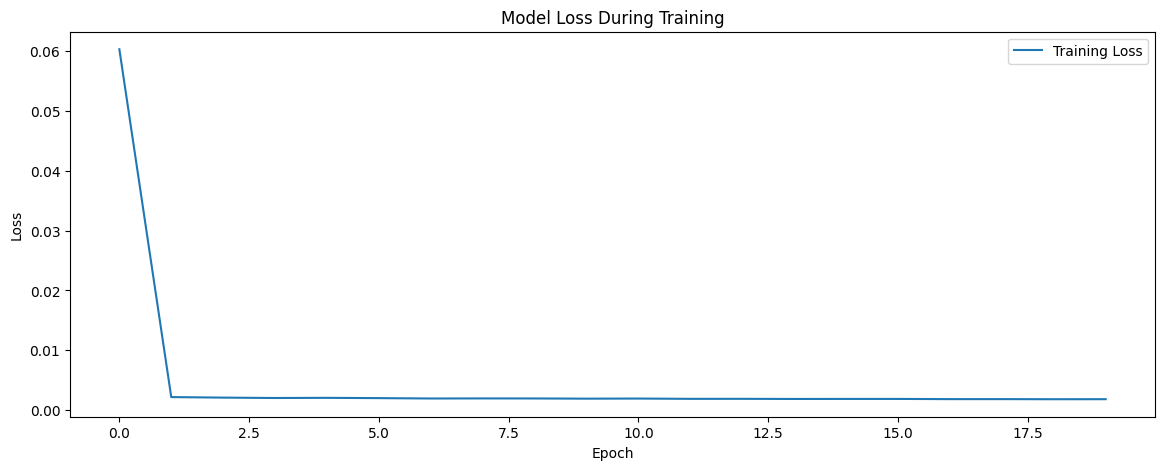

In [48]:
# 13. Plot training loss
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
actual_prices = y_inv.flatten()
predicted_prices = predictions_inv.flatten()